In [ ]:
# -*- coding: utf-8 -*-
'''
论文题目：基于深度学习的PSA过程优化与控制
作    者：余秀鑫
单    位：天津大学化工学院
时    间：2022.04.12
'''

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
from tqdm import tqdm # Progress bar

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

# For LSTM model
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tqdm.keras import TqdmCallback

from gekko import GEKKO
sns.set_theme(style="ticks", font='Times New Roman', font_scale=1.4)

# 读取训练数据

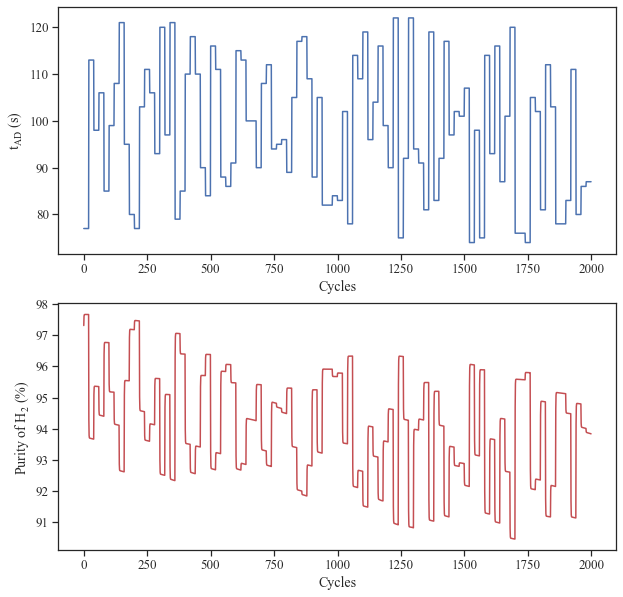

In [2]:
Dataset1 = pd.read_csv('Data\Dataset1.csv')

plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams['axes.unicode_minus']=False

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,10))
ax1.plot(Dataset1['t_AD (s)'],alpha=1)
ax1.set_xlabel('Cycles',fontsize=14)
ax1.set_ylabel('$\mathregular{t_{AD}}$ (s)',fontsize=14)
ax1.tick_params(labelsize='13')

ax2.plot(Dataset1['H2_Purity (%)'],'r',alpha=1)
ax2.set_xlabel('Cycles',fontsize=14)
ax2.set_ylabel('Purity of $\mathregular{H_2}$ (%)',fontsize=14)
ax2.tick_params(labelsize='13')

# 读取LSTM网络用于模拟PSA过程

In [ ]:
model = tf.keras.models.load_model('LSTM_Model')

In [23]:
Train_X = np.load('Train_Test_Data/Train_X.npy').reshape((1999, 2))
Train_y = np.load('Train_Test_Data/Train_y.npy').reshape((1999, 1))
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(Train_X)
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(Train_y)

def LSTM_Predict(X):
    X_scaled = scaler_X.transform(X).reshape((1,1,2))
    y_pred_scaled = model.predict(X_scaled).reshape((X_scaled.shape[0],1))
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    return y_pred.squeeze()

In [24]:
# 测试模型准确性
LSTM_Predict([[80,99]])

array(99.00121, dtype=float32)

# 模型识别

In [3]:
# load data and parse into columns
t = Dataset1['Run']
u = Dataset1['t_AD (s)']
y = Dataset1['H2_Purity (%)']

# generate time-series model
m = GEKKO(remote=False)

# system identification
na=2; nb=2 # use 2nd order model
print('Identify model')
yp,p,K = m.sysid(lstm = model,t,u,y,na,nb,objf=10000,scale=False,diaglevel=0,pred='model')

Identify model
sysid recommendation: switch to pred='meas' for faster solution


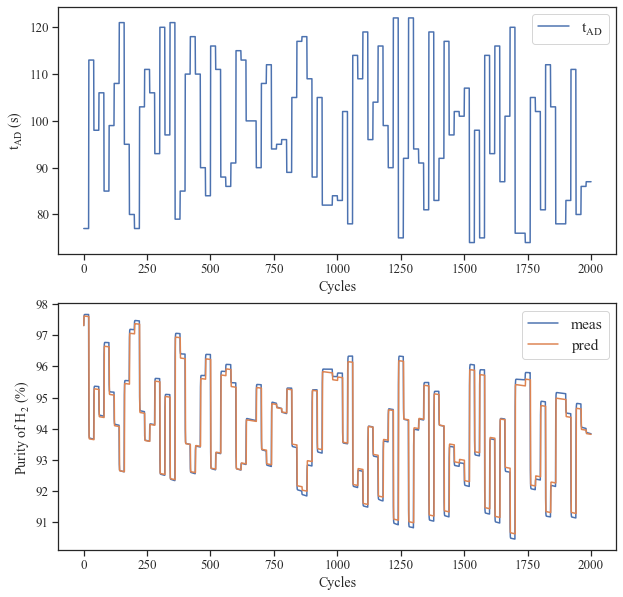

In [4]:
plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams['axes.unicode_minus']=False

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,10))
ax1.plot(t,u)
ax1.legend(['$\mathregular{t_{AD}}$'])
ax1.set_xlabel('Cycles',fontsize=14)
ax1.set_ylabel('$\mathregular{t_{AD}}$ (s)',fontsize=14)
ax1.tick_params(labelsize='13')

ax2.plot(t,y)
ax2.plot(t,yp)
ax2.legend(['meas','pred'])
ax2.set_xlabel('Cycles',fontsize=14)
ax2.set_ylabel('Purity of $\mathregular{H_2}$ (%)',fontsize=14)
ax2.tick_params(labelsize='13')

# 设置控制器

In [61]:
# create control ARX model
m = GEKKO(remote=False)
m.y = m.Array(m.CV,1)
m.u = m.Array(m.MV,1)
m.arx(p,m.y,m.u)

# rename CVs
m.H2Purity = m.y[0]

# rename MVs
m.tAD = m.u[0]

# steady state initialization
m.options.IMODE = 1
m.solve(disp=False)

# set up MPC
m.options.IMODE   = 6 # MPC
m.options.CV_TYPE = 2 # Objective type
m.options.NODES   = 1 # Collocation nodes
m.options.SOLVER  = 1 # APOPT
m.time=np.linspace(0,60,61)

# Manipulated variables
m.tAD.STATUS = 1  # manipulated
m.tAD.FSTATUS = 0 # not measured
m.tAD.DMAX = 50
m.tAD.DCOST = 1
m.tAD.UPPER = 122
m.tAD.LOWER = 75

# Controlled variables
m.H2Purity.STATUS = 1     # drive to set point
m.H2Purity.FSTATUS = 1    # receive measurement
m.H2Purity.TAU = 2        # response speed (time constant)
m.H2Purity.TR_INIT = 2    # reference trajectory
m.H2Purity.TR_OPEN = 5

In [62]:
def mpc(m,H2Purity,H2Puritysp):
    # Insert measurements
    m.H2Purity.MEAS = H2Purity

    # Adjust setpoints
    db1 = 2 # dead-band
    m.H2Purity.SP   = H2Puritysp
    m.H2Purity.SPHI = H2Puritysp + db1
    m.H2Purity.SPLO = H2Puritysp - db1

    # Adjust heaters with MPC
    m.solve(disp=False)

    if m.options.APPSTATUS == 1:
        # Retrieve new values
        tAD  = m.tAD.NEWVAL
    else:
        # Solution failed
        tAD  = 98.0
    return [tAD]

# 设置SP

Text(0, 0.5, '$\\mathregular{H_2}$ Purity Set Point')

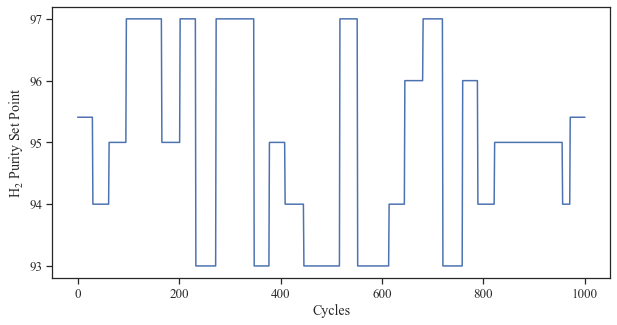

In [79]:
##### Set up run parameters #####
loops = 1000 # cycles

# arrays for storing data
tm = np.linspace(0,loops,loops+1) # Time
H2Purity = np.zeros(len(tm)) # measured H2Purity
tAD = np.zeros(len(tm)) # Heater values

# H2Purity set point
H2Puritysp = np.ones(len(tm)) * 95.4073

# vary temperature setpoint
end = 30 # leave first 20 cycles of set point as room
while end <= loops:
    start = end
    # keep new set point value for 50 cycles
    end += random.randint(30,40)
    H2Puritysp[start:end] = random.randint(93,97)
H2Puritysp[-30:] = H2Puritysp[0] # last 20 cycles at room

# Plot
plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(tm, H2Puritysp)
plt.xticks(fontsize=13) #默认字体大小为10
plt.yticks(fontsize=13)
plt.xlabel('Cycles',fontsize=14)
plt.ylabel('$\mathregular{H_2}$ Purity Set Point',fontsize=14)

# 实施MPC控制

In [81]:
import socket
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)  # IPV4,TCP协议
sock.bind(("192.168.31.242", 54377))  # 绑定ip和端口，bind接受的是一个元组
sock.listen(5)  # 设置监听，其值阻塞队列长度，一共可以有5+1个客户端和服务器连接
print("start server")

start server


In [84]:
# Data collection of MPC
i = 0
tAD[0] = 98
for t in range(len(tm)-1):
    # 发送数据
    s = str(tAD[i])  # 将数据转化为String
    connection, address = sock.accept()  # 等待客户请求
    buf = str(connection.recv(40960), encoding="utf-8")  # 接收数据,并存入buf
    print(buf)
    print("Send new t_AD to MATLAB : {}".format(s))
    connection.send(bytes(s, encoding="utf8"))  # 发送数据
    connection.close()  # 关闭连接
    time.sleep(1)

    # 接受数据
    connection, address = sock.accept()  # 等待客户请求
    buf = str(connection.recv(40960), encoding="utf-8")  # 接收数据,并存入buf
    print("Get new H2 Purity from MATLAB : {}".format(buf))  # 打印客户端地址与信息
    connection.close()  # 关闭连接
    H2Purity[i] = float(buf)

    # Calculate MPC output
    try:
        [tAD[i+1]] = mpc(m,H2Purity[i],H2Puritysp[i])
    except:
        tAD[i+1] = tAD[i];# catch any failure to converge
    # Write output
    #input_X = np.array([[tAD[i],H2Purity[i]]])
    #print()

    print('Cycle:',t,'H2Purity:',H2Purity[i],'H2Puritysp:',H2Puritysp[i],'tAD:',tAD[i])

    i+=1

Begin an simulation : No.1001
Send new t_AD to MATLAB : 98.0
Get new H2 Purity from MATLAB : 94.3976
Cycle: 0 H2Purity: 94.3976 H2Puritysp: 95.4073 tAD: 98.0
Begin an simulation : No.1002
Send new t_AD to MATLAB : 98.0
Get new H2 Purity from MATLAB : 94.232
Cycle: 1 H2Purity: 94.232 H2Puritysp: 95.4073 tAD: 98.0
Begin an simulation : No.1003
Send new t_AD to MATLAB : 83.061496153
Get new H2 Purity from MATLAB : 95.6731
Cycle: 2 H2Purity: 95.6731 H2Puritysp: 95.4073 tAD: 83.061496153
Begin an simulation : No.1004
Send new t_AD to MATLAB : 84.571564778


KeyboardInterrupt: 

In [85]:
sock.close()  # 关闭服务器

In [83]:
# Save csv file
df = pd.DataFrame()
df['Cycle'] = tm[:i]
df['tAD'] = tAD[:i]
df['H2Purity'] = H2Purity[:i]
df['H2Puritysp'] = H2Puritysp[:i]
df.to_csv('MPC_data_8.csv',index=False)